In [1]:
import quandl
import zipline
import pandas as pd
from zipline.api import record, symbol, order_target_percent, order, order_target
from zipline import run_algorithm
from zipline.finance import commission, slippage
from datetime import datetime
import pytz
from talib import EMA

# silence warnings
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext zipline


In [3]:
%zipline --start=2000-1-1 --end=2018-1-1 -b quandl


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2000-01-03 21:00:00+00:00,NaN,0.0,NaN,4.462677e-03,NaN,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,1,[],0.0
2000-01-04 21:00:00+00:00,0.0,0.0,NaN,8.945269e-03,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,2,[],0.0
2000-01-05 21:00:00+00:00,0.0,0.0,NaN,1.344787e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,3,[],0.0
2000-01-06 21:00:00+00:00,0.0,0.0,NaN,1.797056e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,4,[],0.0
2000-01-07 21:00:00+00:00,0.0,0.0,NaN,2.251343e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,5,[],0.0
2000-01-10 21:00:00+00:00,0.0,0.0,NaN,2.707658e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,6,[],0.0
2000-01-11 21:00:00+00:00,0.0,0.0,NaN,3.166009e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,7,[],0.0
2000-01-12 21:00:00+00:00,0.0,0.0,NaN,3.626405e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,8,[],0.0
2000-01-13 21:00:00+00:00,0.0,0.0,NaN,4.088856e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,9,[],0.0
2000-01-14 21:00:00+00:00,0.0,0.0,NaN,4.553371e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,10,[],0.0


In [4]:
def initialize(context):
    context.sym = symbol('AAPL')
    context.i = 0

    # Explicitly set the commission/slippage to the "old" value until we can
    # rebuild example data.
    # github.com/quantopian/zipline/blob/master/tests/resources/
    # rebuild_example_data#L105
    context.set_commission(commission.PerShare(cost=.0075, min_trade_cost=1.0))
    context.set_slippage(slippage.VolumeShareSlippage())


In [5]:
def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < 300:
        return

    # Compute averages
    # history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(context.sym, 'price', 100, '1d').mean()
    long_mavg = data.history(context.sym, 'price', 300, '1d').mean()

    # Trading logic
    if short_mavg > long_mavg:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        order_target(context.sym, 100)
    elif short_mavg < long_mavg:
        order_target(context.sym, 0)

    # Save values for later inspection
    record(AAPL=data.current(context.sym, "price"),
           short_mavg=short_mavg,
           long_mavg=long_mavg)


In [6]:
def analyze(context=None, results=None):
    import matplotlib.pyplot as plt
    import logbook
    logbook.StderrHandler().push_application()
    log = logbook.Logger('Algorithm')

    fig = plt.figure(figsize=(18,14))
    ax1 = fig.add_subplot(211)
    results.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio value (USD)')

    ax2 = fig.add_subplot(212)
    ax2.set_ylabel('Price (USD)')

    # If data has been record()ed, then plot it.
    # Otherwise, log the fact that no data has been recorded.
    if ('AAPL' in results and 'short_mavg' in results and
            'long_mavg' in results):
        results['AAPL'].plot(ax=ax2)
        results[['short_mavg', 'long_mavg']].plot(ax=ax2)

        trans = results.ix[[t != [] for t in results.transactions]]
        buys = trans.ix[[t[0]['amount'] > 0 for t in
                         trans.transactions]]
        sells = trans.ix[
            [t[0]['amount'] < 0 for t in trans.transactions]]
        ax2.plot(buys.index, results.short_mavg.ix[buys.index],
                 '^', markersize=10, color='m')
        ax2.plot(sells.index, results.short_mavg.ix[sells.index],
                 'v', markersize=10, color='k')
        plt.legend(loc=0)
    else:
        msg = 'AAPL, short_mavg & long_mavg data not captured using record().'
        ax2.annotate(msg, xy=(0.1, 0.5))
        log.info(msg)

    plt.show()

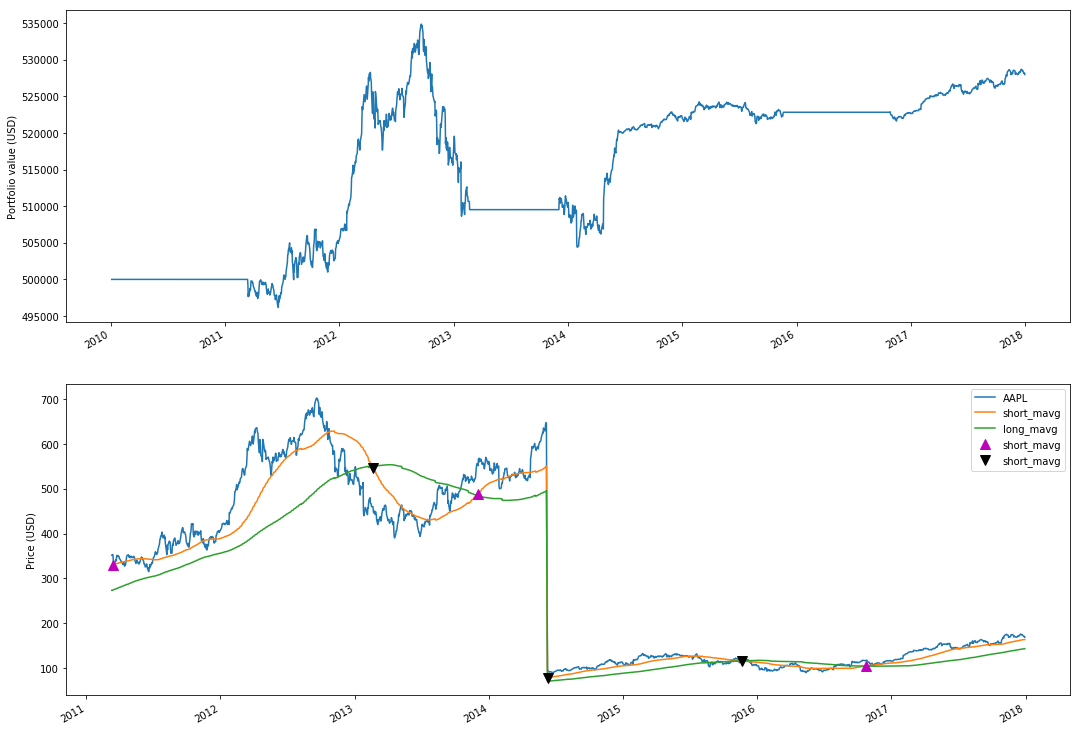

In [7]:
import matplotlib.pyplot as plt
# Set up the stuff for running the trading simulation
base_capital = 500000
start = datetime(2010, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2018, 1, 1, 0, 0, 0, 0, pytz.utc)
# run the trading algorithm and save the results in perf
perf = run_algorithm(start, end, initialize, base_capital, handle_data,
        bundle = 'quandl', analyze=analyze)

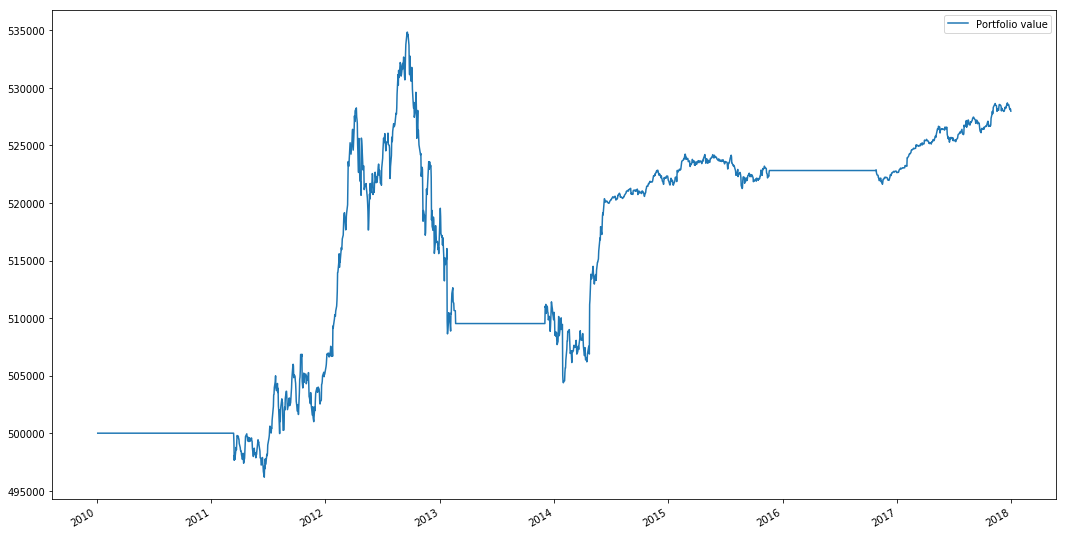

In [12]:
# Draw a nice plot of the value of our portfolio and save it
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
perf.portfolio_value.plot(label="Portfolio value")
# This is was generated by the run_algorithm
plt.legend()
plt.savefig('returns_appl2.png')


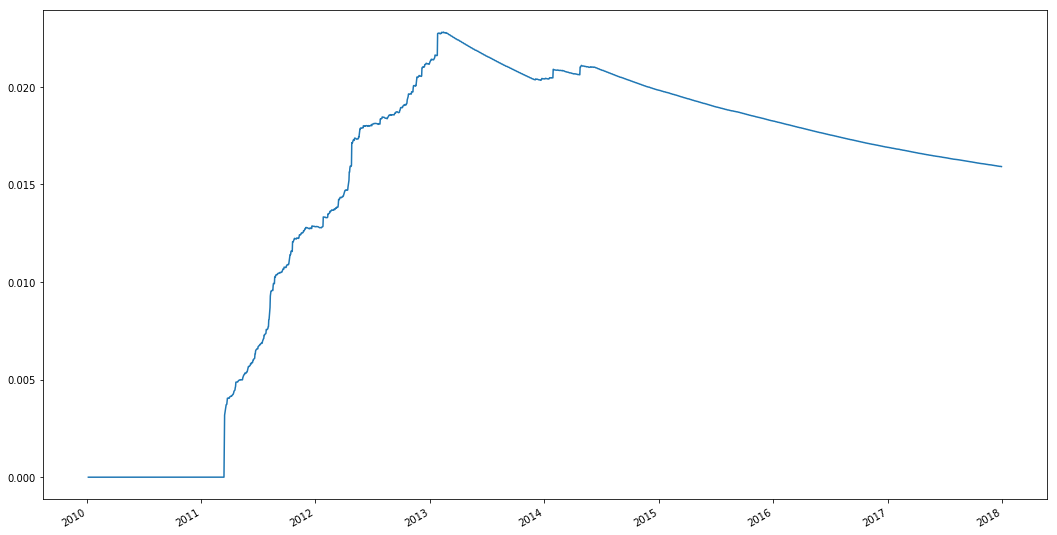

In [13]:
plt.figure(figsize=(18,10))
perf.algo_volatility.plot(label="Volatility")

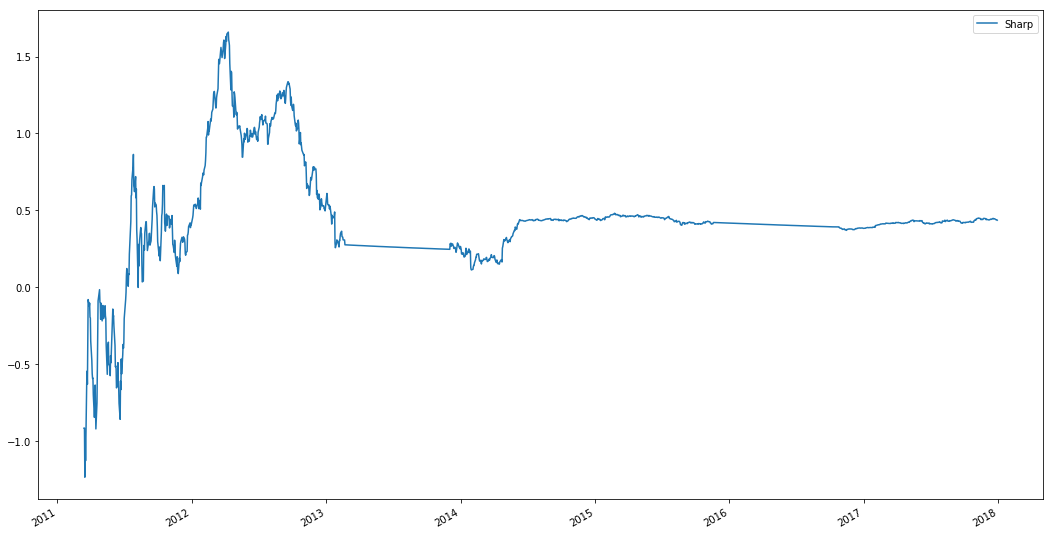

In [14]:
plt.figure(figsize=(18,10))
perf.sharpe.plot(label="Sharp")
plt.legend()

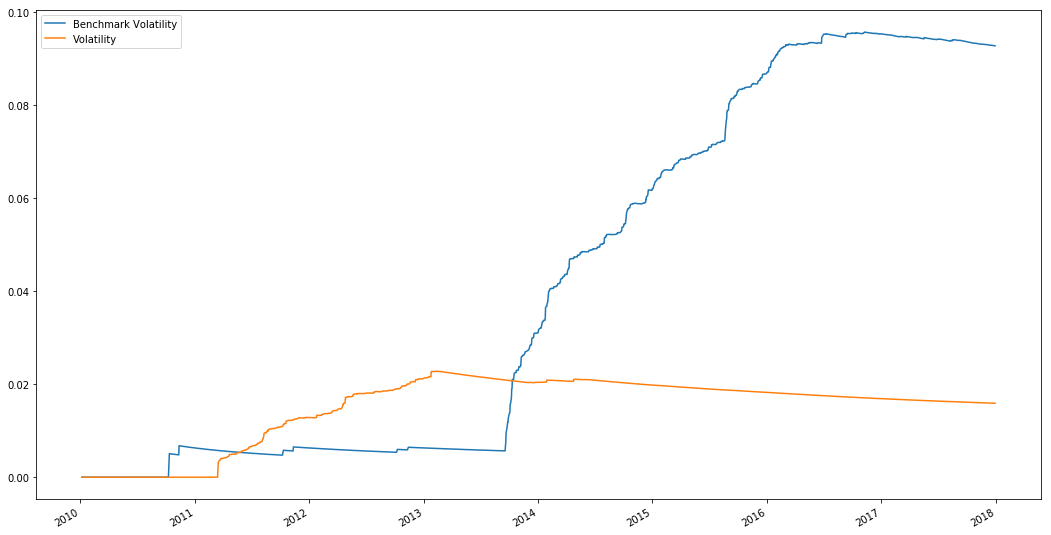

In [15]:
plt.figure(figsize=(18,10))
perf.benchmark_volatility.plot(label="Benchmark Volatility")
perf.algo_volatility.plot(label="Volatility")
plt.legend()